# SpeedyWeather.jl showcase

An introduction to interactive climate modelling.
- Repository: https://github.com/SpeedyWeather/SpeedyWeather.jl
- Documentation: https://speedyweather.github.io

In [ ]:
using Pkg
Pkg.activate(".")
Pkg.resolve()

If you don't have access to the `Project.toml` file in this folder execute the following lines

In [4]:
# Pkg.add(["GLMakie", "GeoMakie", "SpeedyWeather", "TravellingSailorProblem"])

# 1. Discretizing the sphere

SpeedyWeather solves different equations of motions on the sphere using numerically a spectral transform to solve for parts of the equations with spherical harmonics and other parts on grid. What grid do we use?

In [2]:
using SpeedyWeather, GLMakie, GeoMakie

In [3]:
grid = OctahedralGaussianGrid(24)

48-ring OctahedralGaussianGrid
├ nlat_half=24 (3168 points, ~3.6˚, reduced)
└ architecture: CPU

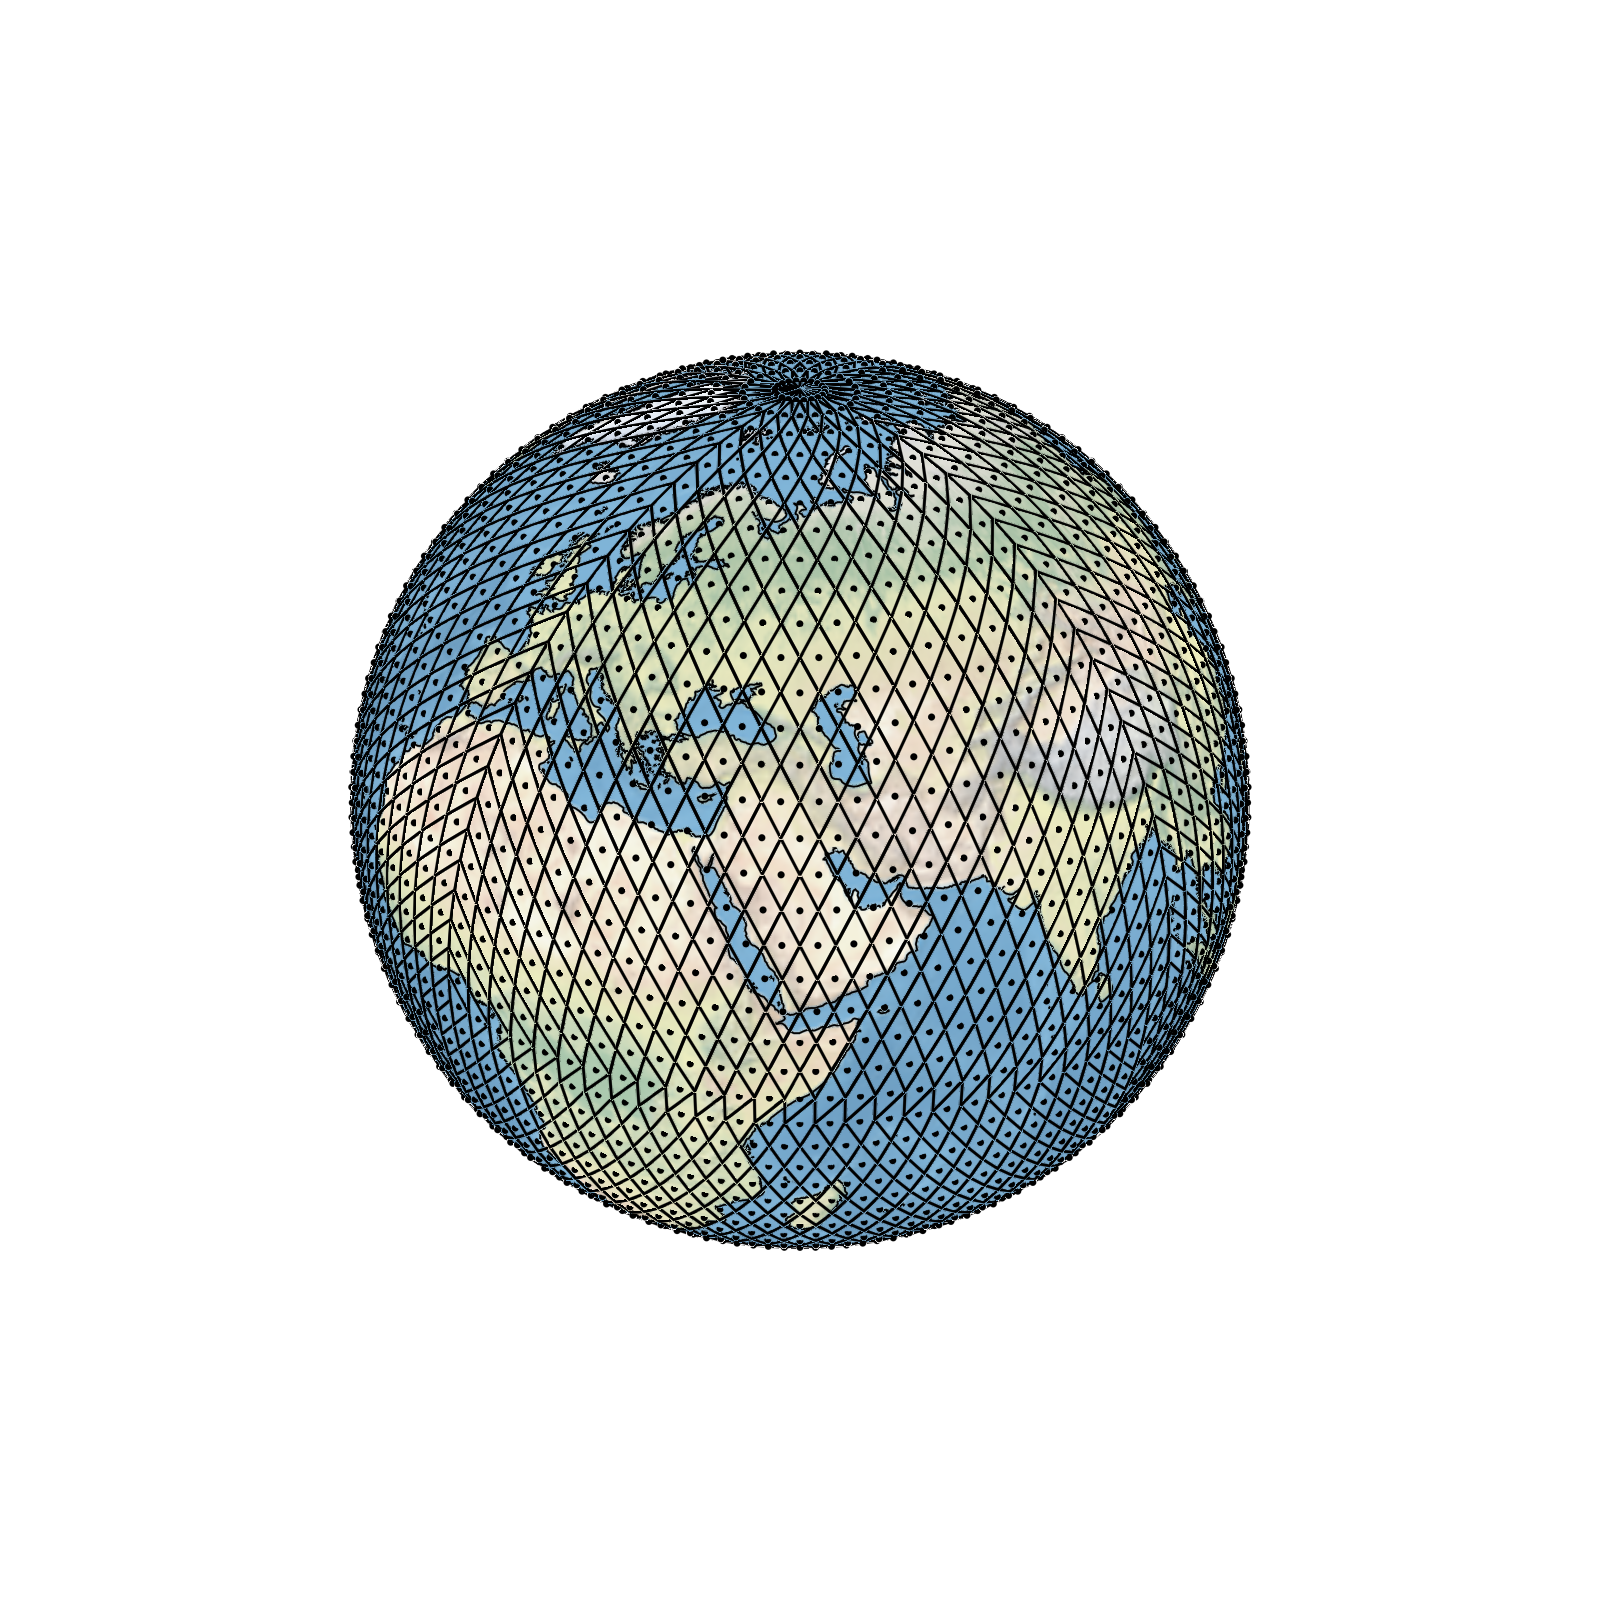

In [4]:
globe(grid)

# 1. Barotropic vorticity + Kolmogorov Flow

Add a sinusoidal forcing in zonal direction (i.e. applied to $u$) varying with latitude $\varphi$

$$
\partial_t u = ... + a \sin(m \varphi)
$$

with amplitude $a$, wavenumber $m$. How to do this?


### Define a new KolmogorovFlow type

In [5]:
@kwdef mutable struct MyKolmogorovFlow <: SpeedyWeather.AbstractForcing
    amplitude::Float32 = 2e-5
    wavenumber::Int = 8
end

MyKolmogorovFlow

In [6]:
function SpeedyWeather.forcing!(       # this is a predefined function
    diagn::DiagnosticVariables,
    progn::PrognosticVariables,
    forcing::MyKolmogorovFlow,         # <- which has to be extended for our new forcing type!
    lf::Integer,
    model::AbstractModel,
)
    # scale by radius as is the vorticity equation
    a = forcing.amplitude * diagn.scale[]
    m = forcing.wavenumber

    Fu = diagn.tendencies.u_tend_grid
    set!(Fu, (λ, φ, σ) -> a*sind(m*φ), model.geometry)
end

### Create the spectral grid

In [52]:
spectral_grid = SpectralGrid(trunc=127, nlayers=1)

SpectralGrid{Spectrum{...}, OctahedralGaussianGrid{...}}
├ Number format: Float32
├ Spectral:      T127 LowerTriangularMatrix
├ Grid:          192-ring OctahedralGaussianGrid, 40320 grid points
├ Resolution:    1.01°, 112km (at 6371km radius)
├ Vertical:      1-layer atmosphere
└ Architecture:  CPU using Array

### Create the new forcing

In [53]:
my_forcing = MyKolmogorovFlow(wavenumber=2)                    # our new forcing

MyKolmogorovFlow <: SpeedyWeather.AbstractForcing
├ amplitude::Float32 = 2.0e-5
└ wavenumber::Int64 = 2

### Construct the model

In [54]:
model = BarotropicModel(spectral_grid; forcing = my_forcing)   # pass it on

BarotropicModel <: Barotropic
├ spectral_grid: SpectralGrid{CPU{KernelAbstractions.CPU}, Spectrum{CPU{KernelAbstractions.CPU}...
├ architecture: CPU{KernelAbstractions.CPU}
├ geometry: Geometry{SpectralGrid{CPU{KernelAbstractions.CPU}, Spectrum{CPU{KernelAbstractions....
├ planet: Earth{Float32}
├ atmosphere: EarthDryAtmosphere{Float32}
├ coriolis: Coriolis{Vector{Float32}}
├ forcing: MyKolmogorovFlow
├ drag: LinearVorticityDrag{Float32}
├ particle_advection: Nothing
├ initial_conditions: InitialConditions{RandomVelocity{Float32}, ZeroInitially, ZeroInitially, ...
├ random_process: Nothing
├ tracers: Dict{Symbol, Tracer}
├ time_stepping: Leapfrog{Float32}
├ spectral_transform: SpectralTransform{Float32, CPU{KernelAbstractions.CPU}, Array, Spectrum{C...
├ implicit: Nothing
├ horizontal_diffusion: HyperDiffusion{Float32, Matrix{Float32}}
├ output: NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{CPU{KernelAbstractio...
├ callbacks: Dict{Symbol, SpeedyWeather.AbstractCallb

### Initialize the model and allocate its variables -> simulation

This steps allows all components to talk to each other, initializes them, and allocates the variables

In [55]:
simulation = initialize!(model)

Simulation{BarotropicModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::BarotropicModel{...}

### Run the model!

In [62]:
run!(simulation, period=Day(1))

 100% ━━━━━━━━━━━━━━━━━━━━  Time: 0:00:00 (2000-01-13, 408.08 years/day, 26 m/s)


### And visualise it!

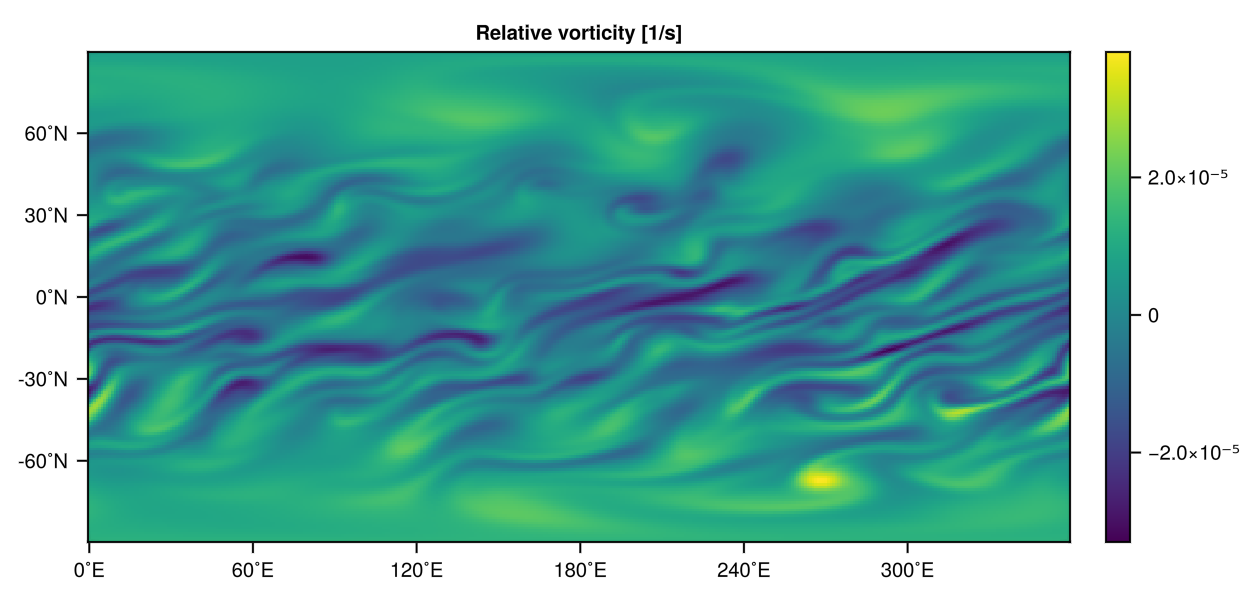

In [63]:
vor = simulation.diagnostic_variables.grid.vor_grid[:, 1]  # vorticity on layer 1
heatmap(vor, title="Relative vorticity [1/s]")

### Let's spin the planet the other way around!

Where do the diagonal stripes come from? Is it coriolis? Let's find out!

In [64]:
model.coriolis.f .*= -1

192-element Vector{Float32}:
 -928.81934
 -928.50995
 -927.9534
 -927.1497
 -926.0991
 -924.8018
 -923.2583
 -921.4688
 -919.4339
 -917.1542
 -914.6301
 -911.86255
 -908.85205
    ⋮
  911.86255
  914.6301
  917.1542
  919.4339
  921.4688
  923.2583
  924.8018
  926.0991
  927.1497
  927.9534
  928.50995
  928.81934

### Continue the same simulation

 100% ━━━━━━━━━━━━━━━━━━━━  Time: 0:00:00 (2000-02-14, 406.56 years/day, 34 m/s)


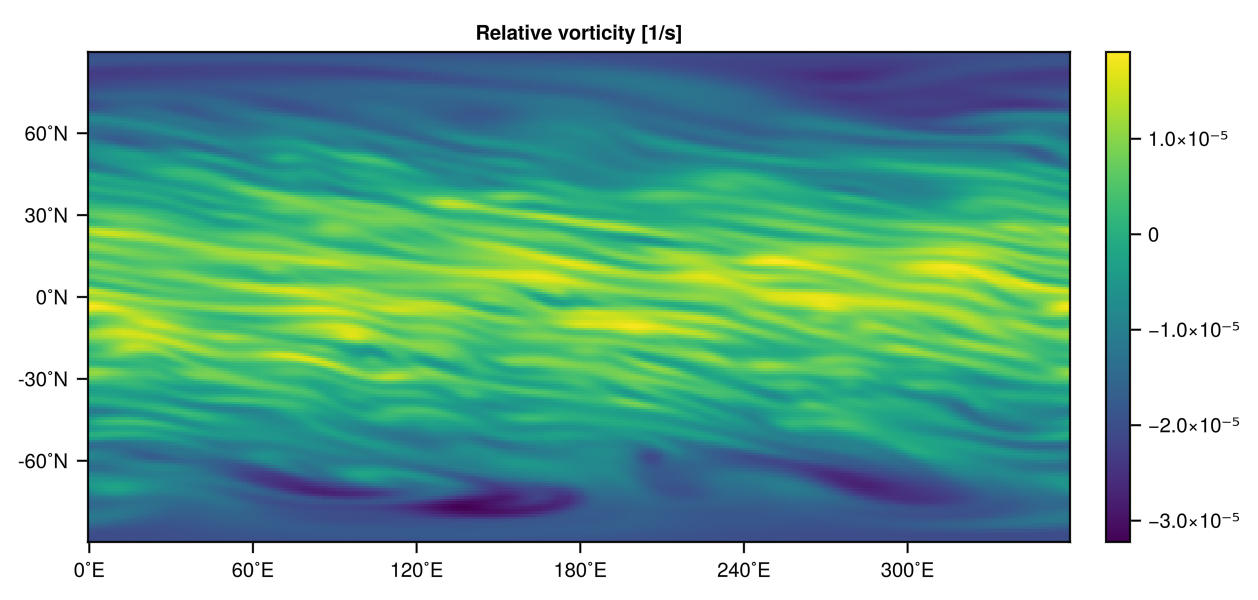

In [73]:
run!(simulation, period=Day(1))
vor = simulation.diagnostic_variables.grid.vor_grid[:, 1]  # vorticity on layer 1
heatmap(vor, title="Relative vorticity [1/s]")

### Let's turn the forcing around

In [67]:
model.forcing.amplitude

2.0f-5

In [68]:
model.forcing.amplitude *= -1

-2.0f-5

### And continue the simulation again

 100% ━━━━━━━━━━━━━━━━━━━━  Time: 0:00:05 (2000-02-13, 424.00 years/day, 33 m/s)


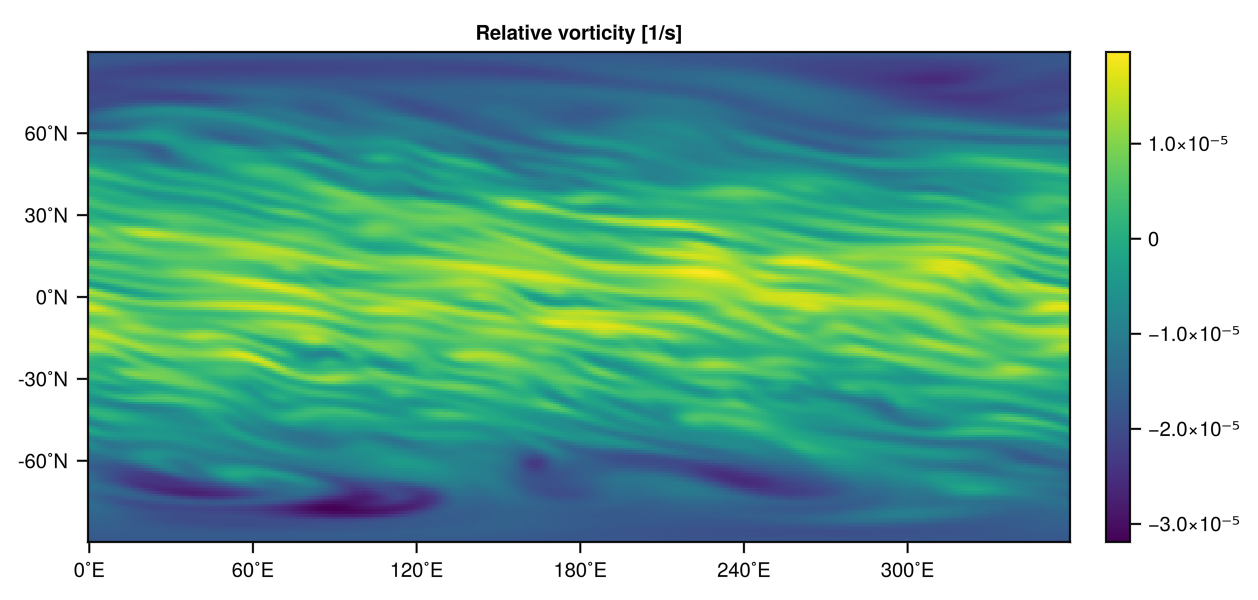

In [71]:
run!(simulation, period=Day(10))
vor = simulation.diagnostic_variables.grid.vor_grid[:, 1]  # vorticity on layer 1
heatmap(vor, title="Relative vorticity [1/s]")

So it turns out no, the diagonal stripes are a result of the sinusoidal shape of the forcing!

### A 3D atmopsheric (+climate) simulation

Now we use `nlayer > 1` to have a vertical dimension

In [89]:
spectral_grid = SpectralGrid(trunc=63, nlayers=8)

SpectralGrid{Spectrum{...}, OctahedralGaussianGrid{...}}
├ Number format: Float32
├ Spectral:      T63 LowerTriangularMatrix
├ Grid:          96-ring OctahedralGaussianGrid, 10944 grid points
├ Resolution:    1.94°, 216km (at 6371km radius)
├ Vertical:      8-layer atmosphere
└ Architecture:  CPU using Array

### Create the default PrimitiveWetModel

In [90]:
model = PrimitiveWetModel(spectral_grid)

PrimitiveWetModel <: PrimitiveWet
├ spectral_grid: SpectralGrid{CPU{KernelAbstractions.CPU}, Spectrum{CPU{KernelAbstractions.CPU}...
├ architecture: CPU{KernelAbstractions.CPU}
├ dynamics: Bool
├ geometry: Geometry{SpectralGrid{CPU{KernelAbstractions.CPU}, Spectrum{CPU{KernelAbstractions....
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Vector{Float32}}
├ geopotential: Geopotential{Vector{Float32}}
├ adiabatic_conversion: AdiabaticConversion{Vector{Float32}}
├ particle_advection: Nothing
├ initial_conditions: InitialConditions{ZonalWind{Float32}, PressureOnOrography, JablonowskiTem...
├ forcing: Nothing
├ drag: SpeedLimitDrag{Float32}
├ random_process: Nothing
├ tracers: Dict{Symbol, Tracer}
├ orography: EarthOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{...
├ land_sea_mask: EarthLandSeaMask{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussia...
├ ocean: SlabOcean{Float32}
├ sea_ice: ThermodynamicSeaIce{Flo

And initialize as before

In [91]:
simulation = initialize!(model)

Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [92]:
run!(simulation, period = Day(10))

 100% ━━━━━━━━━━━━━━━━━━━━  Time: 0:00:20 (2000-01-11, 115.54 years/day, 71 m/s, [-84, 42] ˚C)


### Add some netCDF output

Let us output all sorts of variables to get an idea of the complexity of the simulation

In [80]:
model.output.output_dt = Hour(3)
add!(model, SpeedyWeather.AllOutputVariables())

NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ status: active
├ write restart file: true (if active)
├ interpolator: AnvilInterpolator{Float32, RingGrids.GridGeometry{OctahedralGaussianGrid{CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Vector{Float32}, Vector{Int64}, Vector{UnitRange{Int64}}}, RingGrids.AnvilLocator{Vector{Float32}, Vector{Int64}}}
├ path: /Users/milan/git/PolarPlunge.jl/03_NumericalEarth/run_0001/output.nc (overwrite=false)
├ frequency: 10800 seconds
└┐ variables:
 ├ roff: river runoff [m]
 ├ sma: soil moisture availability [1]
 ├ rain_conv: accumulated convective rain [mm]
 ├ random_pattern: random pattern [1]
 ├ sru: Surface shortwave radiation up [W/m^2]
 ├ rain_cond: accumulated large-scale rain [mm]
 ├ lsm: land-sea mask (1=land, 0=sea) [1]
 ├ v10: 10m meridional wind speed [m/s]
 ├ st: soil temperature [degC]
 ├ tsurf: Surface air temperature [deg

In [81]:
run!(simulation, period = Day(10), output=true)

 run_0002 100% ━━━━━━━━━━━━━━━━━━━━  Time: 0:00:31 (2000-01-31, 76.15 years/day, 82 m/s, [-82, 35] ˚C)m


### Dimming the sun: How cold does it get?

In [93]:
model.planet = Earth(spectral_grid, solar_constant=0)

Earth{Float32} <: SpeedyWeather.AbstractPlanet
├ radius::Float32 = 6.371e6
├ rotation::Float32 = 7.29e-5
├ gravity::Float32 = 9.81
├ daily_cycle::Bool = true
├ length_of_day::Second = 86400 seconds
├ seasonal_cycle::Bool = true
├ length_of_year::Second = 31557600 seconds
├ equinox::DateTime = 2000-03-20T00:00:00
├ axial_tilt::Float32 = 23.4
└ solar_constant::Float32 = 0.0

In [96]:
run!(simulation, period = Day(10))

 100% ━━━━━━━━━━━━━━━━━━━━  Time: 0:00:19 (2000-01-31, 120.14 years/day, 81 m/s, [-82, 12] ˚C)


### How far has sea ice reached?

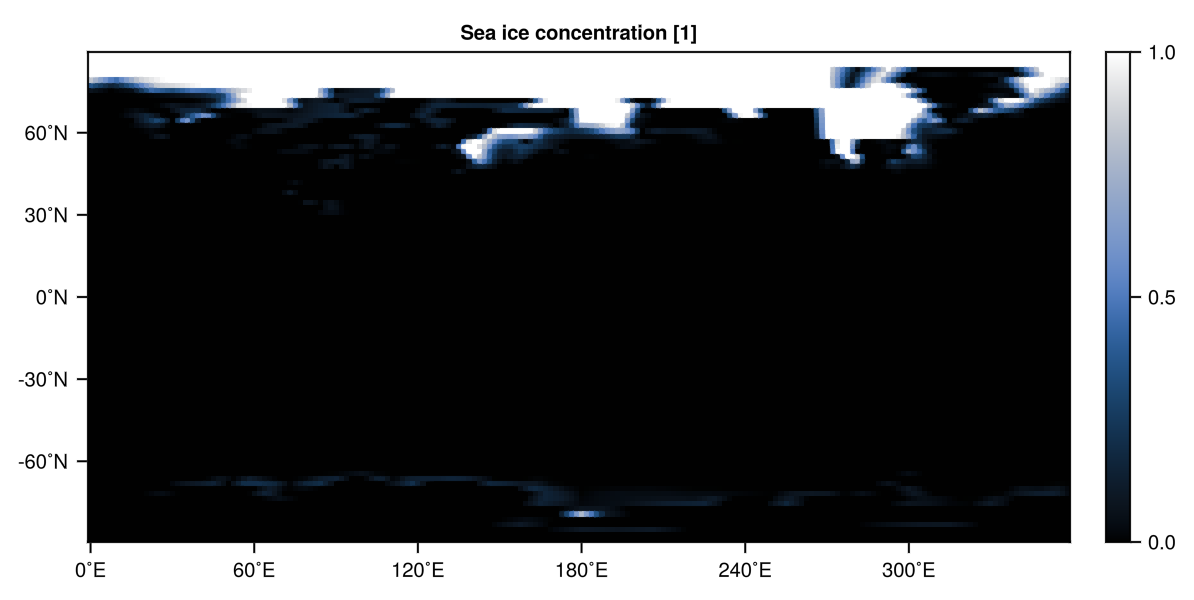

In [103]:
sic = simulation.prognostic_variables.ocean.sea_ice_concentration
heatmap(sic, title="Sea ice concentration [1]", colormap=:oslo)

Clearly the sea ice hasn't even reached the mid-latitudes yet! Ocean and land have a lot of thermal inertia!

### What about land temperatures?

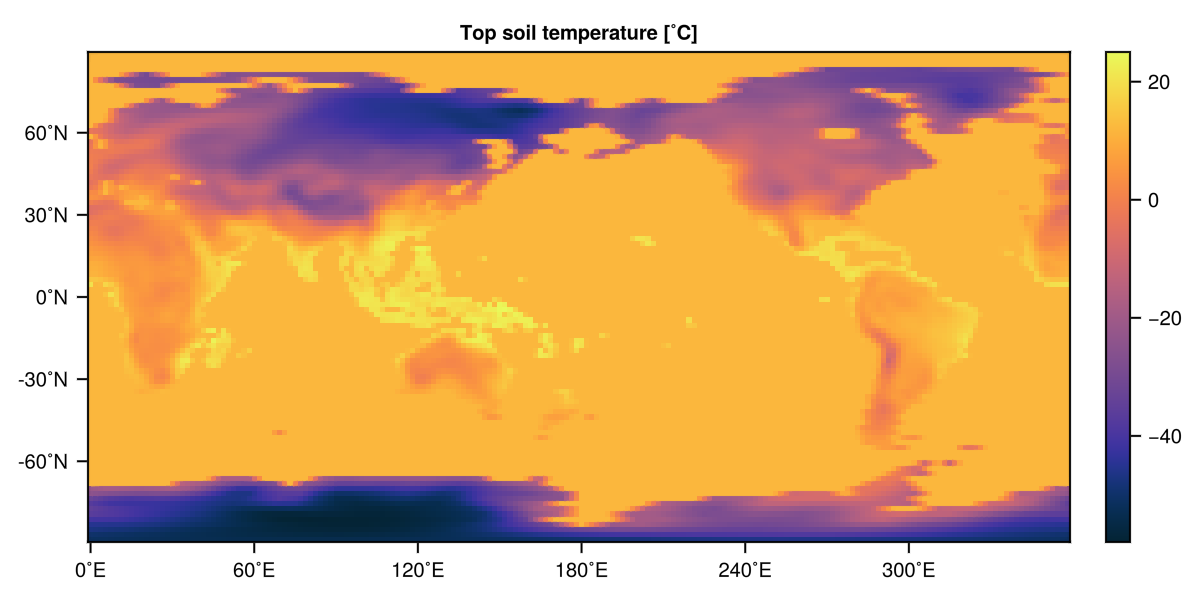

In [102]:
lst = simulation.prognostic_variables.land.soil_temperature[:, 1] .- 273.15
heatmap(lst, title="Top soil temperature [˚C]", colormap=:thermal)

### And sea surface temperatures?

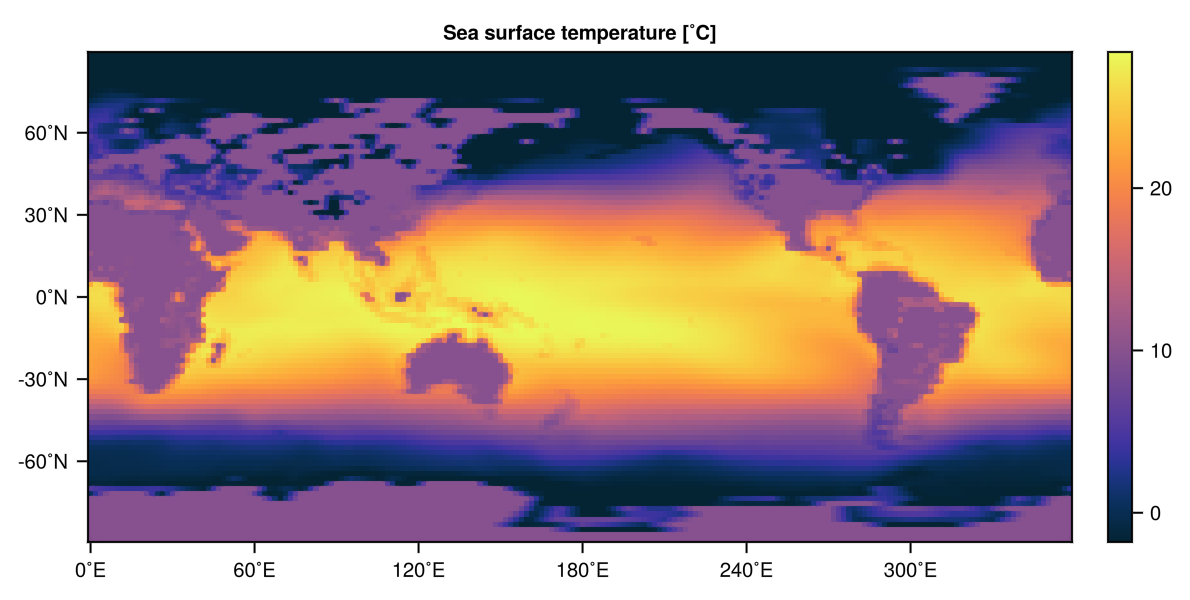

In [101]:
sst = simulation.prognostic_variables.ocean.sea_surface_temperature[:, 1] .- 273.15
heatmap(sst, title="Sea surface temperature [˚C]", colormap=:thermal)

They have barely cooled down!!

### Let's go crazy! Mt Everest in the Indian ocean

In [104]:
spectral_grid = SpectralGrid(trunc=63, nlayers=8)
model = PrimitiveWetModel(spectral_grid)
simulation = initialize!(model)

Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

After the `initialize!` call (which initializes boundary conditions the _right_ way around)
we modify a field before running the simulation

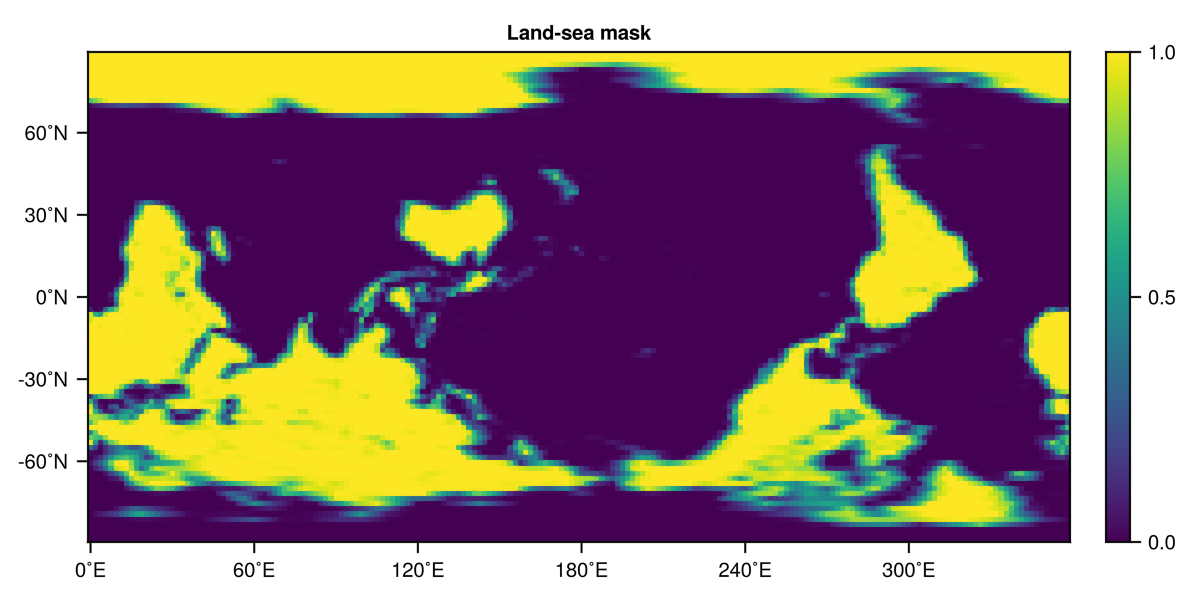

In [106]:
reverse!(model.land_sea_mask.mask, dims=:lat)
heatmap(model.land_sea_mask.mask, title="Land-sea mask")

How would that affect the world? Soil moisture, ...

 100% ━━━━━━━━━━━━━━━━━━━━  Time: 0:00:07 (2000-01-05, 120.71 years/day, 49 m/s, [-88, 43] ˚C)


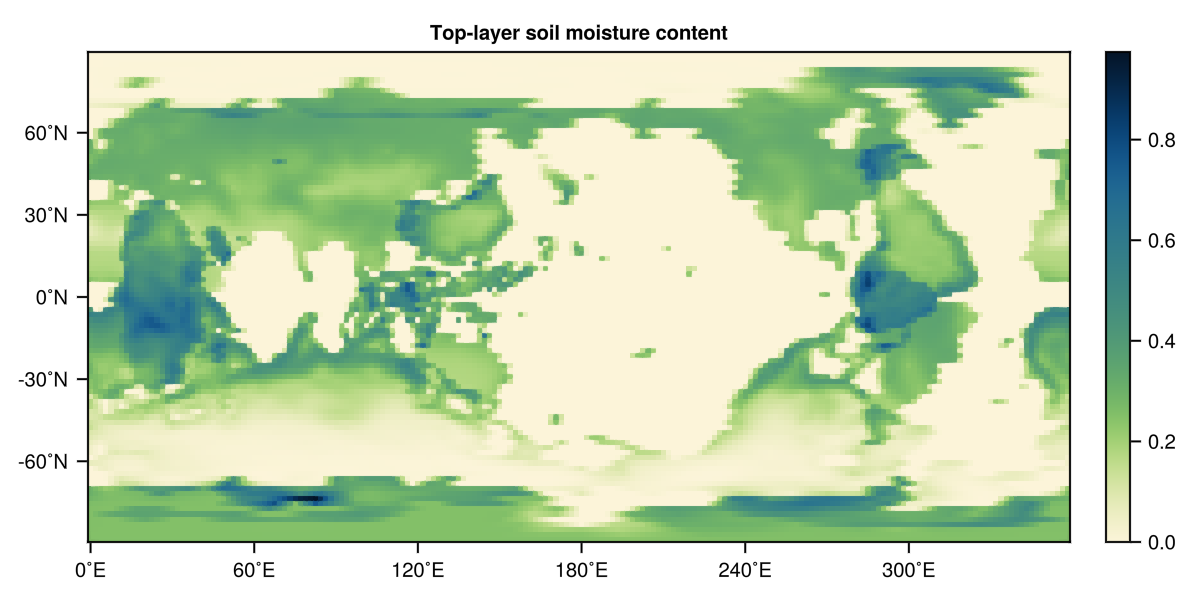

In [107]:
run!(simulation, period=Day(4))

# visualise soil moisture
soil_moisture = simulation.prognostic_variables.land.soil_moisture[:, 1]
heatmap(soil_moisture, title="Top-layer soil moisture content", colormap=Reverse(:navia))

Now there's a ghost Asian continent between "Africa" and "Australia" and a ghost North America appears of the Chilean cost

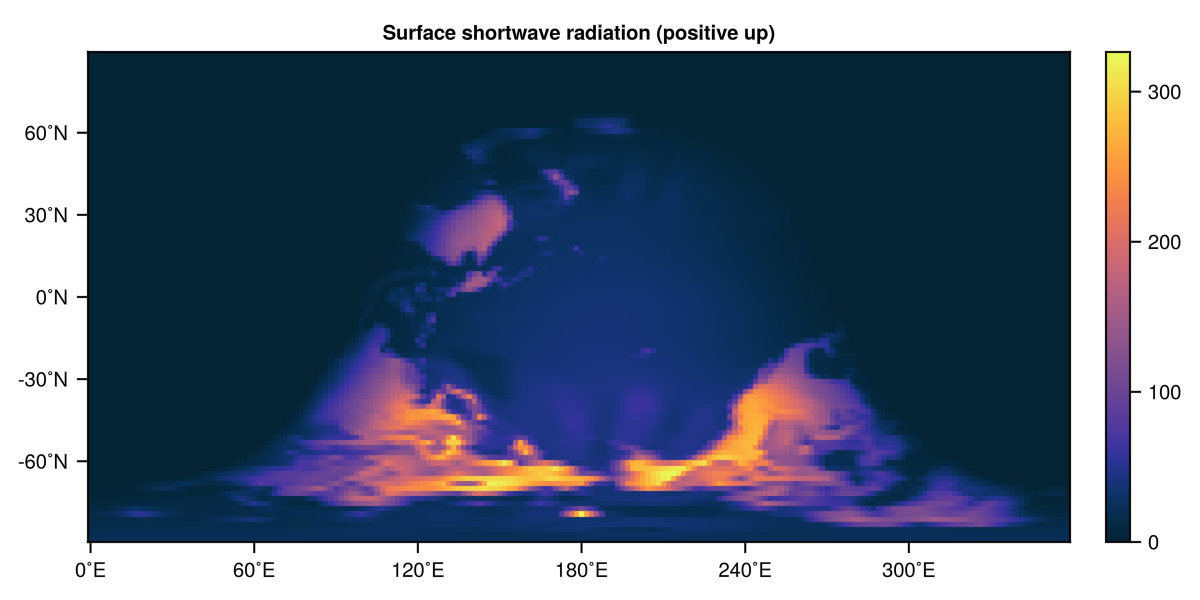

In [109]:
sru = simulation.diagnostic_variables.physics.surface_shortwave_up
heatmap(sru, title="Surface shortwave radiation (positive up)", colormap=:thermal)

# Volcanic eruption in the Pacific?

Just set the orography to something else!

In [126]:
spectral_grid = SpectralGrid(trunc=63, nlayers=8)
model = PrimitiveWetModel(spectral_grid)
add!(model, Tracer(:ash))   # <- add a tracer!!!
simulation = initialize!(model)

Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

# Now we add the mountain

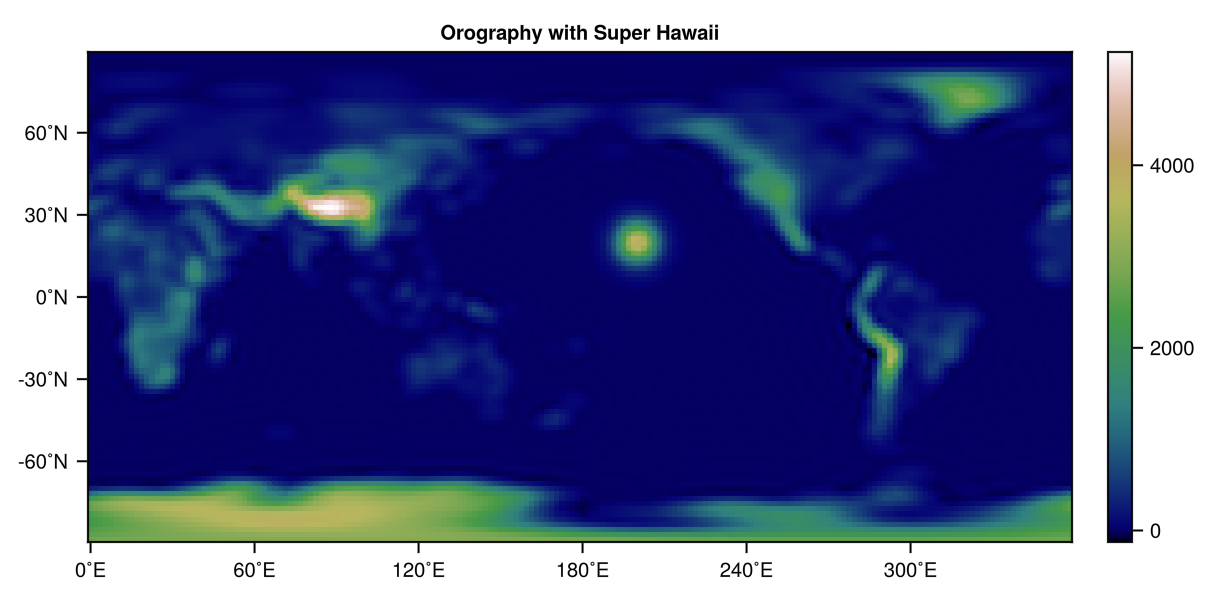

In [127]:
H, λ₀, φ₀, w = 4000, 200, 20, 5         # height, lon, lat position, and width
set!(model, orography=(λ,φ) -> H*exp((-(λ-λ₀)^2 - (φ-φ₀)^2)/2w^2), add=true)
heatmap(model.orography.orography, title="Orography with Super Hawaii", colormap=:gist_earth)

# And the initial conditions of ash

In [129]:
f(λ, φ, σ) = σ < 0.5 ? 0 : σ*exp((-(λ-λ₀)^2 - (φ-φ₀)^2)/2(3w)^2)
set!(simulation, ash = f)

 100% ━━━━━━━━━━━━━━━━━━━━  Time: 0:00:03 (2000-01-06, 76.69 years/day, 55 m/s, [-88, 42] ˚C)m


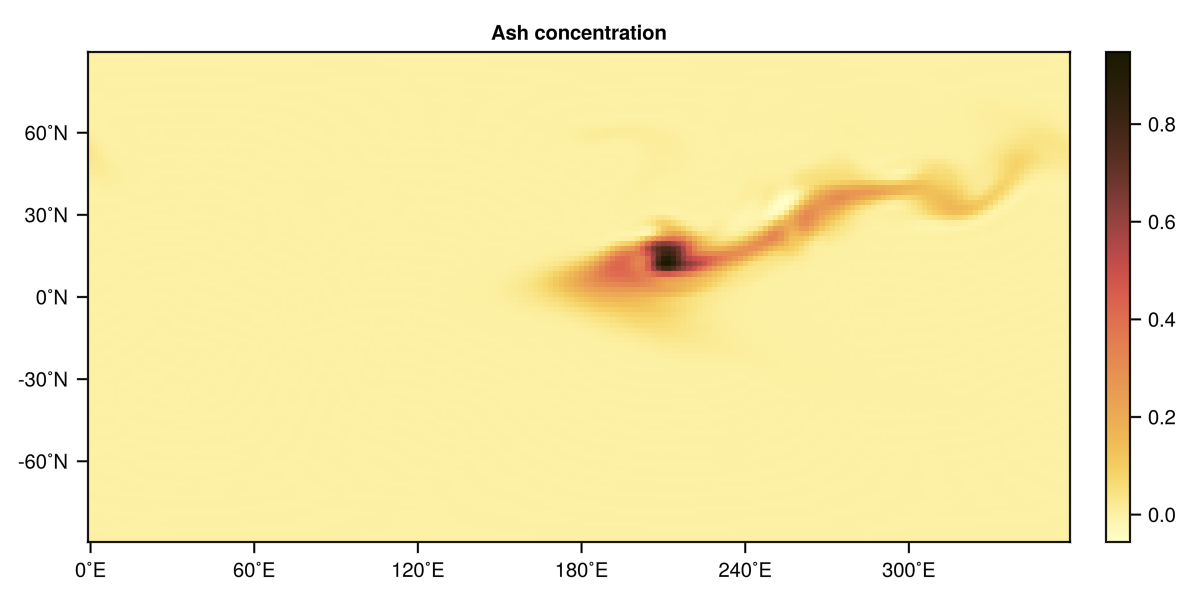

In [134]:
run!(simulation, period=Day(1))
ash = simulation.diagnostic_variables.grid.tracers_grid[:ash][:, 5]
heatmap(ash, title="Ash concentration", colormap = Reverse(:lajolla))

# Particles 🎈🎈🎈

Let us add some particles that fly around the world, blown by the wind. Particle advection has to be defined and pass on to the model constructor otherwise the particles would just stay where they are!

In [ ]:
using TravellingSailorProblem

N = 100
spectral_grid = SpectralGrid(trunc=31, nlayers=8, nparticles=N)
particle_advection = ParticleAdvection2D(spectral_grid, layer=8)
model = PrimitiveWetModel(spectral_grid; particle_advection)
simulation = initialize!(model)

# add particle tracker

by default the particles would not be tracked, so let's `add!` a particle tracker for visualisation later

In [ ]:
particle_tracker = ParticleTracker(spectral_grid)
add!(model, :particle_tracker => particle_tracker)

# adjust initial locations of particles

We'll place the particles around our new volcano on Hawai'i!

In [ ]:
(; particles) = simulation.prognostic_variables
particles .= [Particle(λ₀ + randn(), φ₀ + randn()) for i in 1:N]

# then run! simulation for a month

In [ ]:
run!(simulation, period=Day(30))

# plot a cool visualisation!

In [ ]:
globe(children, particle_tracker)